# ASTR3110 Tutorial 3: Fitting Models

Tutorial 3 of the *'Data Science Techniques in Astrophysics'* course at Macquarie University.

## Learning outcomes from this tutorial

 * Understand the process of optimization
 * Understand what 'gradient descent' is
 * Fit a simple 1D spectrum with a polynomial model
 * Understand how to write code to use scipy optimisers

## Setup for Google Drive

As with the tutorial last week, we will be operating on actual data, so please mount your Google Drive:

In [ ]:
# Comment out if running locally
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
# Get into the correct directory
#cd gdrive/MyDrive

We will be processing a polarised radio spectrum taken using the [Australia Telescope Compact Array](https://www.narrabri.atnf.csiro.au/) towards the galaxy [NGC612](https://arxiv.org/pdf/1801.08237.pdf). The file is available on the ASTR3110 GithHub page at this link: [HotSpot.csv](https://github.com/MQ-ASTR3110/ASTR3110_Tutorial_Notebooks_2022/blob/master/DATA/HotSpot.csv). If you've cloned the ASTR3110 github repository and are running the notebook stub from there, the DATA directory should have updated to include this file. If not, save this file to your Google Drive under, for example, your 'DATA/' directory.

First take a look at the file format and load the data into a Pandas dataframe:

In [1]:
# Name of the data file containing the spectra:
specFile = "DATA/HotSpot.csv"

#'head' is a unix command that shows the first N rows
# Use head to display the 1st 5 lines of the data file. 
!head -5 $specFile

frequency_Hz,I_mJy,Q_mJy,U_mJy,dI_mJy,dQ_mJy,dU_mJy
1332000000.0,0.404449,-0.075177,0.02592,0.008107,0.001971,0.002355
1348000000.0,0.398738,-0.0771,0.025128,0.008707,0.002349,0.002444
1364000000.0,0.401036,-0.076211,0.02373,0.008689,0.002173,0.002123
1380000000.0,0.400293,-0.075793,0.026654,0.008767,0.001875,0.002241


The file contains 7 columns corresponding to polarised radio-frequency spectra as [Stokes Parameters](https://en.wikipedia.org/wiki/Stokes_parameters) - Stokes I is the standard radio flux measurement in [mJy](https://en.wikipedia.org/wiki/Jansky). 

[frequency_Hz, I_mJy, Q_mJy, U_mJy, dI_mJy, dQ_mJy, dU_mJy]

We will want to access the columns frequency_Hz, I_mJy (flux in milly Janskies) and dI_mJy (uncertainty in flux). Start by reading all of the file into a Pandas dataframe:

In [2]:
import pandas as pd
#Same as in last week's lectorial, we'll use pandas to read the csv 
#file into a data frame:
specDF=pd.read_csv(specFile)#"DATA/HotSpot.csv")



As always, take a look at the dataframe:

In [3]:
#take a look at the first 10 rows:
specDF.head()

,frequency_Hz,I_mJy,Q_mJy,U_mJy,dI_mJy,dQ_mJy,dU_mJy
0,1.332000e+09,0.404449,-0.075177,0.025920,0.008107,0.001971,0.002355
1,1.348000e+09,0.398738,-0.077100,0.025128,0.008707,0.002349,0.002444
2,1.364000e+09,0.401036,-0.076211,0.023730,0.008689,0.002173,0.002123
3,1.380000e+09,0.400293,-0.075793,0.026654,0.008767,0.001875,0.002241
4,1.396000e+09,0.394279,-0.075675,0.024194,0.008772,0.001701,0.001971


In [4]:
# The first column is in Hz, so make more manageable by 
# converting to GHz and adding a new column to the dataframe. 
# The reason that this is required is because later we will be fitting
#the data. Very large or small values (away from 1.0)
# can prevent fitting algorithms from converging.
specDF['frequency_GHz'] = specDF['frequency_Hz']/1e9
print("Array has shape (rows, columns):", specDF.shape)

Array has shape (rows, columns): (198, 8)



The values in the frequency column can be accessed via


In [5]:
# Access the frequency column values only (without the index and other stuff normally printed)
specDF['frequency_GHz'].values

array([1.332, 1.348, 1.364, 1.38 , 1.396, 1.412, 1.428, 1.444, 1.46 ,
       1.476, 1.492, 1.524, 1.636, 1.652, 1.668, 1.684, 1.7  , 1.716,
       1.732, 1.748, 1.764, 1.78 , 1.796, 1.812, 1.828, 1.844, 1.86 ,
       1.876, 1.892, 1.924, 1.94 , 1.956, 1.972, 1.988, 2.004, 2.02 ,
       2.036, 2.052, 2.068, 2.084, 2.1  , 2.116, 2.132, 2.148, 2.164,
       2.18 , 2.196, 2.212, 2.228, 2.244, 2.26 , 2.276, 2.292, 2.308,
       2.324, 2.34 , 2.356, 2.372, 2.388, 2.404, 2.42 , 2.436, 2.452,
       2.468, 2.484, 2.5  , 2.516, 2.532, 2.548, 2.564, 2.58 , 2.596,
       2.612, 2.628, 2.644, 2.66 , 2.676, 2.692, 2.708, 2.724, 2.74 ,
       2.756, 2.772, 2.788, 2.804, 2.82 , 2.836, 2.852, 2.868, 2.884,
       2.9  , 2.916, 4.7  , 4.716, 4.732, 4.748, 4.764, 4.78 , 4.796,
       4.812, 4.828, 4.844, 4.86 , 4.876, 4.892, 4.908, 4.924, 4.94 ,
       4.956, 4.972, 4.988, 5.004, 5.02 , 5.036, 5.052, 5.068, 5.084,
       5.1  , 5.116, 5.132, 5.148, 5.164, 5.18 , 5.196, 5.212, 5.228,
       5.244, 5.26 ,

Now plot the spectrum and error bars using ```matplotlib```.

Text(0.5, 1.0, 'Stokes I radio spectrum')

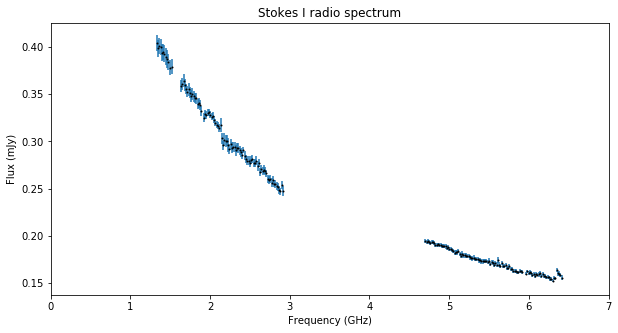

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline 
plt.figure(figsize=(10,5))#Can make the plots bigger so that the points are easier to see.
# Basic commands to plot the spectrum
plt.errorbar(x=specDF['frequency_GHz'], y=specDF['I_mJy'], yerr=specDF['dI_mJy'],
             marker='o', mfc="black", mec='none', markersize=2, 
             linestyle='')#,figsize=(20,10))
plt.xlabel("Frequency (GHz)")
plt.ylabel("Flux (mJy)")
plt.xlim(0,7)
plt.title("Stokes I radio spectrum")

# Here we plot the points using black circles with no edge-line
# and the error bars as vertical blue lines (the default).
# We omit the line joining consecutive points.

The small gaps in frequency coverage are ranges where the data suffered from interference (e.g., from mobile phones) and these channels have been removed.

## Fitting a 1D Polynomial

We are going to fit a 1D polynomial to this data, so we first define a function to evaluate a polynomial. The maximum order of polynomial we are going to use is 5:

$ y(x) = p_0 + p_1 ~x + p_2 ~x^2 +  p_3 ~x^3 + p_4 ~x^4 + p_5 ~x^5$

our function should accept an argument $p = [p_0,~p_1,~p_2,~p_3,~p_4,~p_5]$ containing the polynomial coefficents, and a vector $x = [x_1,~x_2,~\ldots~x_n] $ of values at which to evaluate the polynomial.

In [7]:
def poly5_V0(p, x):
    """
    Evaluate a 5th-order polynomial at values of the vector x.
    """
    y = p[0] + p[1]*x + p[2]*x**2.0 + p[3]*x**3.0 + p[4]*x**4.0 + p[5]*x**5.0
    return y

Define some coefficients and a vector of x-values and evaluate a polynomial:

In [8]:
# The coefficients for a 5th-order polynomial
#p = [0, 0, 2.4, 1.3, 5.0, 8.0]
p = [8.0, 5.0, 1.3, 2.4, 0.3, 2.0]
#p = [80.0, 5.0, 0, 0, 0, 0]

# Create a Numpy array of equaly spaced x-values
import numpy as np
x = np.linspace(start=-15, stop=10, num=20)

# Evaluate the polynomial
y = poly5_V0(p, x)

# Print y vector
y

array([-1.51143700e+06, -9.55132349e+05, -5.76272336e+05, -3.28533841e+05,
       -1.74469727e+05, -8.45622905e+04, -3.62767119e+04, -1.31145068e+04,
       -3.66697578e+03, -6.68655731e+02, -5.07699866e+01,  5.32087449e+00,
        1.46684511e+01,  1.35285912e+02,  1.11469739e+03,  5.23648736e+03,
        1.72668500e+04,  4.54011388e+04,  1.02210416e+05,  2.05588000e+05])

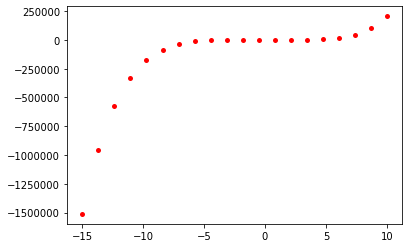

In [9]:
# Plot the polynomial
plt.plot(x, y, marker='o', mfc="red", mec='none', markersize=5, 
             linestyle='')

We will use an *optimisation* routine to find the parameter of the best-fitting polynomial - the model that is closest to the data points. These routines explore the parameter space defined by the vector $p$ (i.e., try different values of $p$) and minimise a *cost function*. One of the most commonly used cost functions is the *least squares* - the sum of the squared residuals between the model and the data:

$${\rm Least~Squares} = \sum_{i=1}^n~(y_{i,~{\rm data}} - y_{i,~{\rm model}})^2$$

where $i$ denotes the $i^{th}$ data point and $n$ is the total number of data points. This is illustrated in the animation below (ref [Wikipedia](https://en.wikipedia.org/wiki/File:Least_Squares.gif)):

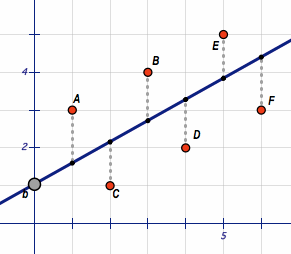

In [10]:
# Display an image from the drive
# the point of optimisation is to find the model parameters that best describe the data, i.e., minimise the
# distance between the model and the data.
from IPython.display import Image
Image(filename='Images/Least_Squares.gif')

For measurements with an uncertainty in the y-coordinate, we normalise by dividing by the square of the error vector $\sigma$. This is called the $\chi^2$ (chi-squared) statistic:

$$\chi^2 = \sum_{i=1}^n~\left(\frac{y_{i,~{\rm data}} - y_{i,~{\rm model}}}{\sigma_{y,~i}}\right)^2$$.

Optimisation routines calculate $\chi^2(p,~x)$ for a set of parameters, evaluate the *gradient of $\chi^2$* in local parameter space and pick a 'nearby' set of $p$ values at a lower $\chi^2$. That is, they iteratively apply a *gradient descent* algorithm to 'walk downhill' to the position where the parameters match the data best. Here is a nice animation by [Sebastian Ruder](https://ruder.io/optimizing-gradient-descent/) illustrating different algorithms walking down a cost function surface:

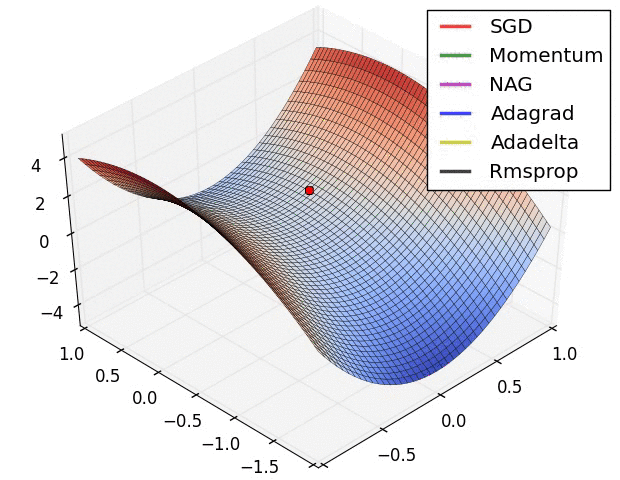

In [11]:
# Display an image from the drive
#describe the surface below. It represents the values of Chi^2 
# for the two parameter combinations at the bottom of the plot. Want
# to find the parameter combinations that minimise the Chi^2 value.
# Gradient descent algorithms choose parameters that move towards lower
# Chi^2 values.
Image(filename='Images/grad_descent.gif')


### 1. Define a function that evaluates the model

Sometimes we may want to fit a lower or higher order coefficient, so we will allow different length $p$ vectors to be passed in. Inside the function we still evaluate a more general Nth order polynomial.

In [12]:

def polyN(p,x):
    
    """
    When called, this function takes a vector of parameters
    and x-values, loops over the order number, and generates an Nth order polynomial.
    """
    y = 0
    for i in np.arange(len(p)):
        y += p[i]*x**float(i)
    # Note the indent here
    return y


Let's see how this compares to the function we defined earlier:

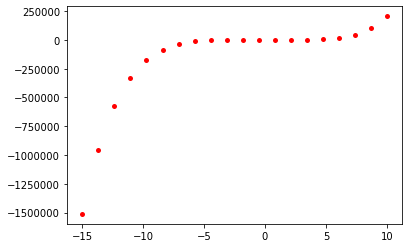

In [13]:
# The coefficients for a 3rd-order polynomial
#p = [0, 0, 2.4, 1.3, 5.0, 8.0]
p = [8.0, 5.0, 1.3, 2.4, 0.3, 2.0]
#p = [80.0, 5.0]

# Create a Numpy array of equaly spaced x-values
x = np.linspace(start=-15, stop=10, num=20)

# Evaluate the polynomial at x values
y = polyN(p,x)#evalPolyFunc(x)

# Plot the result
#use markers, and set the marker face colour (mfc) to red, and the marker edge colour (mec) to none
plt.plot(x, y, marker='o', mfc="red", mec='none', markersize=5, 
             linestyle='')

### 2. Define a $\chi^2$ function to evaluate the current goodness of fit

This function takes the polynomial parameters and data as arguments and evaluates $\chi^2$: the distance between the model and the data, or '*goodness of fit*'.

In [14]:
def chisq(p, xData, yData, dyData):
    """
    Function to evaluate chi-Squared given parameters and data
    """
    
    # Calculate the y values at the given x values
    yModel = polyN(p,xData)

    # Calculate chi-squared value
    chisqValue = np.sum( ((yModel - yData) / dyData)**2 )
    
    return chisqValue

The value of chi-squared for our arbitrary polynomial and spectrum will be very large:

In [15]:
# Set the data arrays from the file
xData = specDF['frequency_GHz'].values
yData = specDF['I_mJy'].values
dyData = specDF['dI_mJy'].values

print(chisq(p, xData, yData, dyData))

4239090784429632.0


### 3. Run the optimiser to find minimum $\chi^2$ value

Now we are ready to run the optimiser to find the best fitting parameters. We will use one of the simplest optimisers provided by the *scipy* module: ```op.fmin``` (use '?' to see the documentation). 

Note that it is **vitally important** that you provide a reasonable a point estimate for the vector of parameters. Estimates that are too far away from the best-fitting values will cause the optimiser to fail. Here we calculate the average 'slope' betwen datapoints as the $p_1$ term and the y-intercept as the $p_0$ term, i.e., an approximate linear fit.

Alternatively, sometimes it is possible to run "global" minimisers, but these can be *very* slow! Check out the [scipy optimize page](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [16]:
import scipy.optimize as op

op.fmin?

In [17]:
import scipy.optimize as op

# Make an estimate of the average 'slope' between 
# points as starting estimate for p_1
# np.diff just takes the difference beteween the (i+1)th and ith data point.
# To get the slope at that point, just divide by delta (x), which is the same
# for all points (modulo where there are missing data).
# This is just a simple way of measuring the mean dy/dx, which
# gives an estimate for the slope of a line!
p_1 = np.nanmean(np.diff(yData) / (xData[1] - xData[0]))

# Choose a non-NaN datapoint to calculate the y-intercept for p_0
validIndices = np.nonzero(~np.isnan(yData))
i = int(np.median(validIndices))        # Choose the middle data point
p_0 = yData[i] - (p_1 * xData[i]) #here just rerranging y = ax+b to get b, the y-intercept. 

# Starting estimate parameter vector
# Set curvature terms to zero. Hopefully this puts
# us close enough to the global minimum.
p0 = [p_0, p_1,0.0, 0.0, 0.0, 0.0]

# Now run the optimiser to fit the model
retVals = op.fmin(chisq,                        # The function to minimise
                  p0,                           # The starting guess
                  args=(xData, yData, dyData),  # The arguments of chisq() after p
                  full_output=1,                # Return warning flags
                  disp=1)                       # Print feedback during iterations

print("The optimiser returned {:d} things".format(len(retVals)))

Optimization terminated successfully.
         Current function value: 117.398452
         Iterations: 405
         Function evaluations: 644
The optimiser returned 5 things


The optimiser ran successfully and returned a tuple with 5 things. From the documentation these are:

* retVals[0] = final value for p vector
* retVals[1] = final value of chisq function
* retVals[2] = number of iterations performed.
* retVals[3] = number of function calls made.
* retVals[4] = warning flag > 0 means hit iteration threshold, 0 means 'success'


In [18]:
# Print each of the entries in turn
print(p0) #compare with our initial guesses. Not bad, in the right ballpark at least.
for i, e in enumerate(retVals):#enumerate is a simple way to add a counter (here, i) 
                               #to an iterable item like the returned tuple
    print("\nEntry {:d}".format(i))
    print(e)

[0.5720377525380707, -0.07897430203045677, 0.0, 0.0, 0.0, 0.0]

Entry 0
[ 6.40477442e-01 -1.80748818e-01 -1.67180188e-02  2.11088165e-02
 -4.06701974e-03  2.46537547e-04]

Entry 1
117.39845240154223

Entry 2
405

Entry 3
644

Entry 4
0


## 4. Plot the best solution and calculate some useful numbers

For completeness, we make a convenience function to plot the best fitting model and the data together:

In [19]:
def plot_spec_polyN(p, xData, yData, dyData):
    """
    Function to plot the model polynomial over the datapoints.
    """
    
    # Make a model curve, sampled at smaller intervals to appear smooth
    nSamples = 100
    xModel = np.linspace(start=np.min(xData), 
                         stop=np.max(xData), 
                         num=nSamples)
    yModel = polyN(p,xModel)#evaluate the model so we ccan overplot on top of the data

    # Setup the figure. Slightly different setup to above, but same outcome.
    fig = plt.figure()
    fig.set_size_inches([12,12])
    ax = fig.add_subplot(1,1,1)
    
    # First plot the data
    ax.errorbar(x=xData, y=yData, yerr=dyData, mfc="none", 
                ms=4, fmt="D", ecolor="grey", label="Data",
                elinewidth=1.0, capsize=2)
    
    # The plot the model 
    ax.plot(xModel, yModel, color="red", marker="None", mfc="w",
            mec="g", label="Model", lw=2.0)
    
    # Set the lables
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('Amplitude (mJy)')

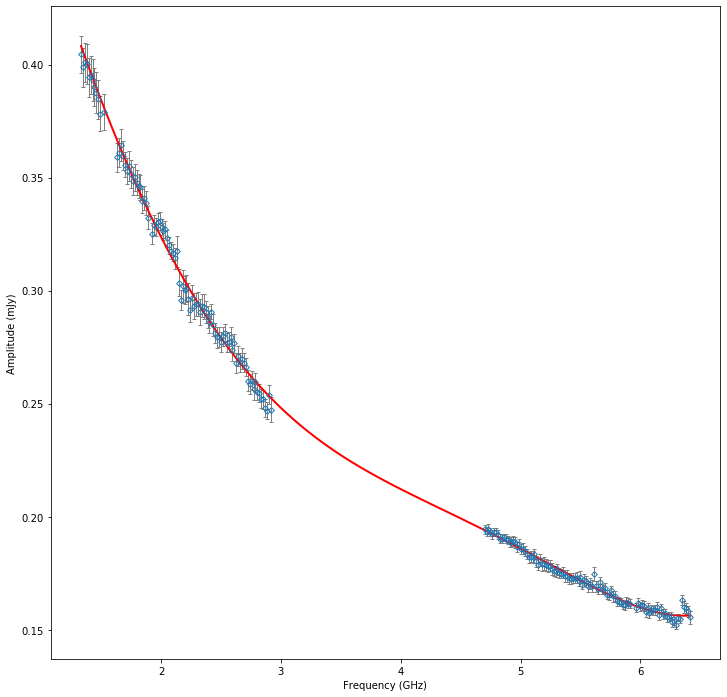

In [20]:
# Access the best-fit polynomial coefficients
pFit = retVals[0]

# Plot the best fitting model
plot_spec_polyN(pFit, xData, yData, dyData)

We can print some useful numbers to assess how good our best-fit model is. In particular, the reduced chi-squared value can be used to assess how well the model fits the data (although [see here for a warning](https://arxiv.org/pdf/1012.3754.pdf)):

$${\rm Degrees~of~freedom}~~~N_{\rm DOF} = N_{\rm datapoints} - N_{\rm parameters} -1$$

$$\chi^2_{\rm reduced} = \chi^2 / N_{\rm DOF}$$

In [21]:
# Access the final value for chi-squared
chiSqFinal = retVals[1]

# Calculate degrees of freedom and reduced chi-squared
dof = len(xData) - len(p0) - 1
chiSqRed = chiSqFinal / dof
    
# Print the values
print("DOF      = {:d}".format(dof))
print("CHISQ    = {:.4f}".format(chiSqFinal))
print("CHISQred = {:.4f}".format(chiSqRed))

DOF      = 191
CHISQ    = 117.3985
CHISQred = 0.6147


We can see that a 5th order polynomial fits the data very well - maybe too well! Values of $\chi^2_{\rm reduced}$ below 1 indicate that *either* the best-fit line is *overfit*, that is, it describes the data points better than expected given the uncertainties, *or* the given uncertainties are overestimated. We may need to choose a lower-order polynomial. So let's write a more general function so that we can check fits using different polynomial orders.


## 5. A general polynomial fitter

In [22]:
#Did not cover the below in class... Sorry!  
def fit_spec_polyN(xData, yData, dyData, order=5,quiet=False):
    """
    A general function that takes a spectrum and fits
    a polynomial of order N to the data.
    """

    # Catch orders lower than 1
    if order < 1:
        order = 1
    
    # Convert the data into a numpy array -- this is generalised and optimiser takes numpy arrays. 
    # If, e.g., we were using Pandas this line would ensure the correct data was inputted.
    xData = np.array(xData, dtype='f8')
    yData = np.array(yData, dtype='f8')
    
    # Filter out any NaN values (fitters often don't work with NaNs). np.nonzero returns only non-NaN values.
    validIndices = np.nonzero(~np.isnan(yData))
    xData = xData[validIndices]
    yData = yData[validIndices]
    
    # Estimate the starting parameters (same as before, but added in the for loop so we don't have to write 
    # out the higher order part every time.)
    p_1 = np.nanmean(np.diff(yData) / (xData[1] - xData[0])) #slope
    i = int(np.median(np.indices(xData.shape)))
    p_0 = yData[i] - (p_1 * xData[i]) #intercept
    p0=[p_0,p_1]
    for i in np.arange(order-1):#note that only subtract 1, not 2 to get the correct order.
        p0.append(0)

    # Now do the fitting
    retVals = op.fmin(chisq, p0, args=(xData, yData, dyData), 
                      full_output=1, disp=1)# For order=4 add in ftol=0.000001 so that it converges. 
                                            # May also need to add maxiter=10000)
    
    pFit = retVals[0]
    chiSqFinal = retVals[1]
    dof = len(xData) - len(p0) - 1
    chiSqRed = chiSqFinal / dof
    BIC = chiSqFinal + len(p0)*np.log(len(xData)) #Bayesian Information Criterion, useful for model selection
    #print(len(p0))
    
    # Print some feedback if requested
    if not quiet:
        print("DOF      = {:d}".format(dof))
        print("CHISQ    = {:.4f}".format(chiSqFinal))
        print("CHISQred = {:.4f}".format(chiSqRed))
        print("BIC = {:.4f}".format(BIC))
    
    # Return everything useful
    return pFit, chiSqFinal, dof, chiSqRed, BIC

Now try fitting polynomials of different order:

Optimization terminated successfully.
         Current function value: 443.617466
         Iterations: 176
         Function evaluations: 294
DOF      = 192
CHISQ    = 443.6175
CHISQred = 2.3105
BIC = 470.0588


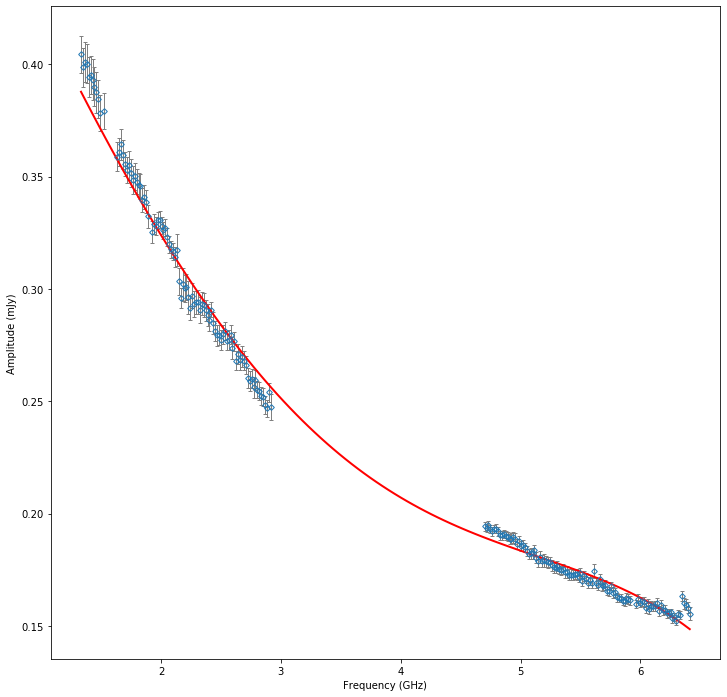

In [23]:
# Fit a 4th order polynomial
pFit, chiSqFinal, dof, chiSqRed, BIC = fit_spec_polyN(xData, yData, dyData, order=4)

# Plot the result
plot_spec_polyN(pFit, xData, yData, dyData)

On my laptop, the 4th order polynomial gave a poorer fit than expected. This is because the fmin optimiser seems to 
get stuck in a local minimum. For these optimisers, there are a couple of criteria that are use to decide when the 
optimiser has converged to the minimum value of the function. If new moves don't change the minimum value by some 
tolerance value, then the code decides it has converged. In this case, the default value of "ftol" was not low enough,
which meant that the optimiser did not find the best fitting parameters. Hence, in the above fit_spec_polyN cell, I
needed to set ftol=0.000001 in order to get a better fit -- try it yourself! Note that in some cases, setting the 
ftol too small leads to slower running times, and the potential to hit the maximum number of allowed iterations 
(which can also be set). The optimiser should return a warning in these cases.

Optimization terminated successfully.
         Current function value: 287.985122
         Iterations: 226
         Function evaluations: 388
DOF      = 193
CHISQ    = 287.9851
CHISQred = 1.4922
BIC = 309.1382


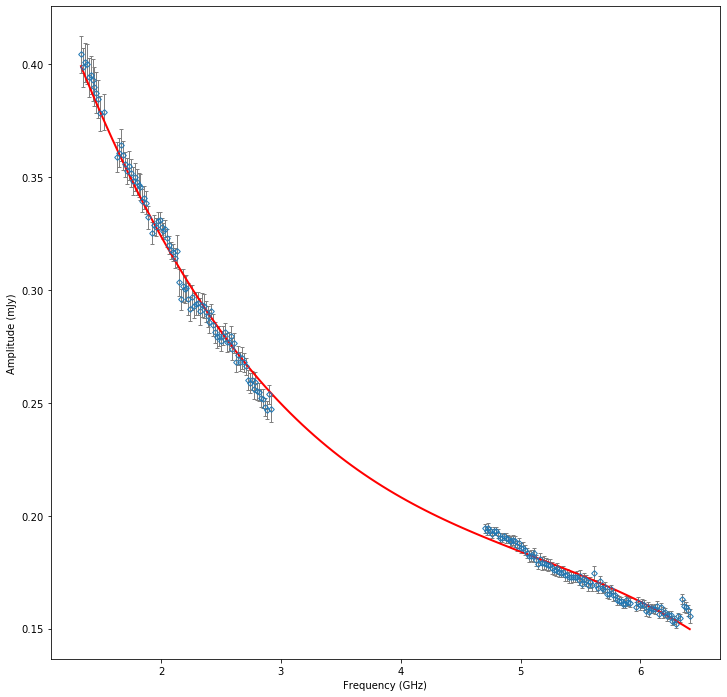

In [24]:
# Fit a 3rd order polynomial
pFit, chiSqFinal, dof, chiSqRed,BIC = fit_spec_polyN(xData, yData, dyData, order=3)

# Plot the result
plot_spec_polyN(pFit, xData, yData, dyData)

Optimization terminated successfully.
         Current function value: 833.949842
         Iterations: 91
         Function evaluations: 168
DOF      = 194
CHISQ    = 833.9498
CHISQred = 4.2987
BIC = 849.8146


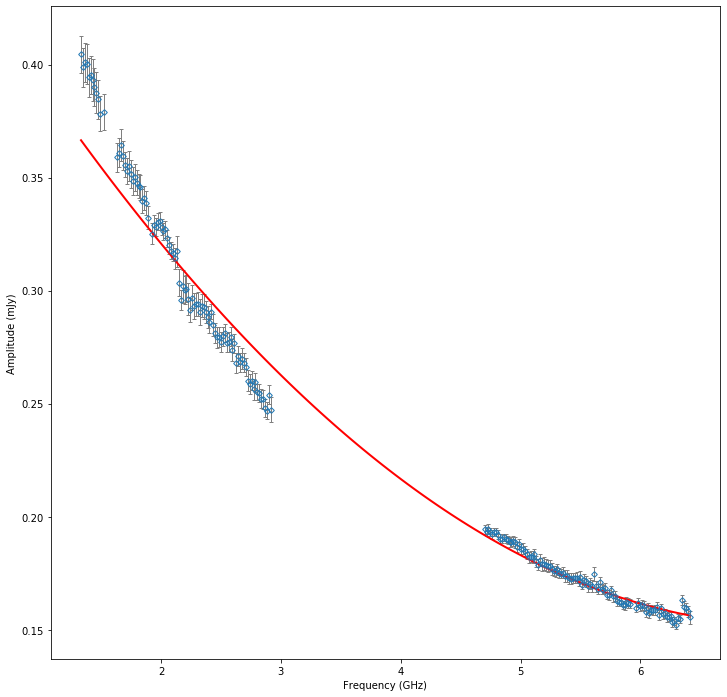

In [25]:
# Fit a 2nd order polynomial
pFit, chiSqFinal, dof, chiSqRed,BIC = fit_spec_polyN(xData, yData, dyData, order=2)

# Plot the result
plot_spec_polyN(pFit, xData, yData, dyData)

Optimization terminated successfully.
         Current function value: 3270.504482
         Iterations: 44
         Function evaluations: 81
DOF      = 195
CHISQ    = 3270.5045
CHISQred = 16.7718
BIC = 3281.0810


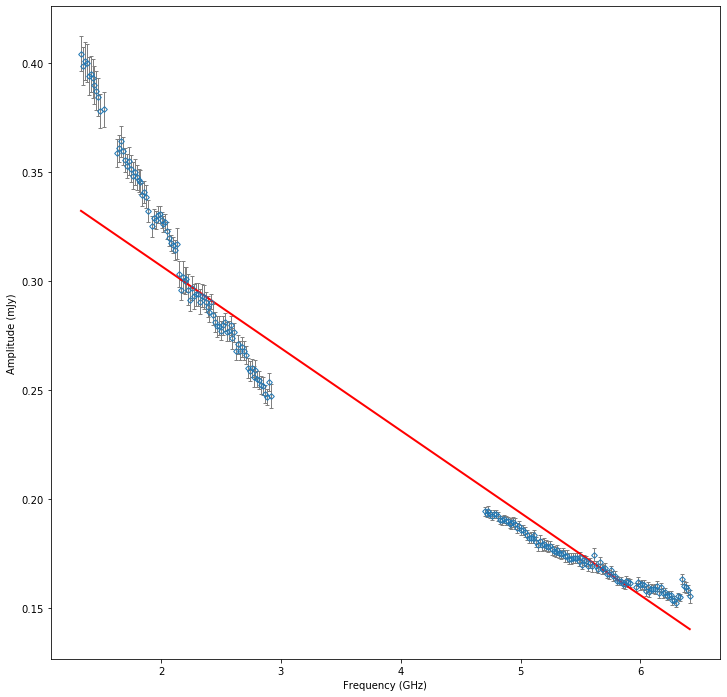

In [26]:
# Fit a straight line
pFit, chiSqFinal, dof, chiSqRed,BIC = fit_spec_polyN(xData, yData, dyData, order=1)

# Plot the result
plot_spec_polyN(pFit, xData, yData, dyData)

Model selection is an important problem in many areas, and commonly comes up in determining the required polynomial order for a given dataset. There are many methods to objectively perform model selection, and one common way is to use the "Bayesian Information Criterion". One implementation of BIC is given by:

$BIC = \chi^2 + N_{\rm parameters} ~{\rm ln}(N_{\rm datapoints})$

Generally, we want to choose the model that returns the lowest BIC value. As can be seen, the term on the right increases the BIC value -- it penalises models that have more parameters. It's an Ockham's razor type penalty. We want the simplest model that best describes our data. In practice, we want to see the BIC decrease by a substantial amount as we increase the model complexity (i.e., increase the number of parameters). This gives confidence that the more complex model is warranted. The rule of thumb is that if the BIC changes by < -6 going from the less- to more-complicated model then there is strong evidence favouring the more complicated model.

In [27]:
# Loop over polynomial order and save the BIC
BIC_Save=[]
for i in np.arange(10):
    pFit, chiSqFinal, dof, chiSqRed, BIC = fit_spec_polyN(xData, yData, dyData, order=i, quiet=True)
    print("Order = ",i," BIC = ",BIC)
    BIC_Save.append(BIC)
    #plot_spec_polyN(pFit, xData, yData, dyData)

Optimization terminated successfully.
         Current function value: 3270.504482
         Iterations: 44
         Function evaluations: 81
Order =  0  BIC =  3281.08101562079
Optimization terminated successfully.
         Current function value: 3270.504482
         Iterations: 44
         Function evaluations: 81
Order =  1  BIC =  3281.08101562079
Optimization terminated successfully.
         Current function value: 833.949842
         Iterations: 91
         Function evaluations: 168
Order =  2  BIC =  849.8146426490366
Optimization terminated successfully.
         Current function value: 287.985122
         Iterations: 226
         Function evaluations: 388
Order =  3  BIC =  309.13819029775465
Optimization terminated successfully.
         Current function value: 443.617466
         Iterations: 176
         Function evaluations: 294
Order =  4  BIC =  470.05880078552406
Optimization terminated successfully.
         Current function value: 117.398452
         Iterations: 405
 

In [28]:
for i, B in enumerate(BIC_Save):
    if i > 0:
        print("Order = ",i," BIC= ",BIC_Save[i]," Delta(BIC)= ",BIC_Save[i]-BIC_Save[i-1])

Order =  1  BIC=  3281.08101562079  Delta(BIC)=  0.0
Order =  2  BIC=  849.8146426490366  Delta(BIC)=  -2431.2663729717533
Order =  3  BIC=  309.13819029775465  Delta(BIC)=  -540.676452351282
Order =  4  BIC=  470.05880078552406  Delta(BIC)=  160.9206104877694
Order =  5  BIC=  149.12805458570944  Delta(BIC)=  -320.9307461998146
Order =  6  BIC=  151.65946246624088  Delta(BIC)=  2.5314078805314466
Order =  7  BIC=  157.4835713528807  Delta(BIC)=  5.824108886639806
Order =  8  BIC=  212.22474618526263  Delta(BIC)=  54.741174832381944
Order =  9  BIC=  164.38079479732215  Delta(BIC)=  -47.84395138794048


It looks like a 5th order polynomial is the best -- BIC increases going from 5th to 6th order, and decreases substantially for each order going from 1st to 5th (when the ftol is set sufficiently low that the 4th order properly converges).